# NLP Project: Making a prediction of the Programming Language base on README.md
"We don't know, what we don't know"  

By: Cody Watson and Eric Escalante  
May 13, 2019  

In this Jupyter Notebook, we will be scraping data from GitHub repository README files. The goal is to build a model that can predict which primary programming language a repository is using, given the text used within the README file.

## Imports
**Import the necessary packages and their use cases for this project:**
> **pandas:** data frames and data manipulation  
> **numpy:** summary statistics  
> **matplotlib:** used for visualizations  
> **seasborn:** fancy visualizations  
> **datetime:** turn the dates into datetime objects / get day of week  
> **warning:** used to ignore python warnings  
> **requests:** to obtain the HTML from the page  
> **unicodedata:** character encoding  
> **BeautifulSoup:** to parse the HTML and obtain the text/data that we want  
> **nltk:** Natual Language Toolkit that allows us to work with human language data  
> **WordCloud:** creates an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance  
> **spaCy:** Used for processing text (here we use it for lemmitization)  
> **unicodedata:** Defines character properties for all Unicode characters (used here for data normalization)  
> **pprint:** Provides a capability to “pretty-print” arbitrary Python data structures in a form which can be used as input to the interpreter  

In [1]:
import unicodedata
import re
import json

import spacy
from spacy.lang.en import English
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import NLP_acquire
from pprint import pprint

import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

## Table of contents
1. [Project Planning](#project-planning)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)
1. [Summary](#summary)

## Project Planning <a name="project-planning"></a>

### Goals  
> Goals for the Project are:  
1. Accurately predict the primary programming language utilizing mutliple programming languages from Github README files
2. Create different WordCloud models showing the top twenty words used within each programming language
3. Build muliple Classification Machine Learning models to accurately predict in which programming language the repository has been written
4. Be sure that we are documenting our thoughts throughout the process to create a readable and reproducible product

### Deliverables
>- A well-documented jupyter notebook that contains the analysis  
>- One or two google slides suitable for a general audience that summarize the findings. Include a well-labelled visualization in the slides.

### Hypotheses
> "C++ programmers are more elitist"

### Thoughts & Questions
> **Thoughts:**  
- Figure out how to apply multiple Classification methods to predict programming language using the repo's README.md
- Figure out how to apply multiple sentiment analysis methods to the data
- Compare and Contrast multiple Corpus using TF-IDF
- We want to learn how utilize Word2Vec for word embedding
- Apply a 'github' image mask/frame to a WordCloud (within the negative/positive space; label each space with different colors)

> **Questions:**  
- Does the sentiment in a given languange vier more towards positive or negative?
- How many graphs can we make this weekend??

## Prepare the Environment <a name="preparation"></a>

**Bring in the data from the prepare file**

In [2]:
df = pd.read_json('data.json')

**Going to see what the top portion looks like to see how we should approach cleaning the data**

In [3]:
df.head()

,language,readme_contents,repo
0,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",twbs/bootstrap
1,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,facebook/react
2,None,This page is available as an easy-to-read webs...,EbookFoundation/free-programming-books
3,None,"<div align=""center"">\n\t<img width=""500"" heigh...",sindresorhus/awesome
4,None,![Web Developer Roadmap - 2019](https://i.imgu...,kamranahmedse/developer-roadmap


**How many Languages does our CSV have?**

In [4]:
df.language.value_counts()

JavaScript          43
Python              22
Go                   7
C++                  6
Java                 6
CSS                  3
Ruby                 2
HTML                 2
Swift                2
Jupyter Notebook     2
TypeScript           1
C                    1
PHP                  1
Assembly             1
Dart                 1
C#                   1
Rust                 1
Name: language, dtype: int64

**Preparation for setting up environment, for NLP**

In [5]:
### pretrained tokenizer (use code if not downloaded)
#nltk.download('punkt')
### removes words that don't really matter (use code if not downloaded)
#nltk.download('stopwords')

**Funtions to clean our readme files**

In [6]:
def basic_clean(text):
    '''
    Function that takes a string and normalized the text using unicodedata
    '''
    text = unicodedata.normalize('NFKD', text.lower())\
        .encode('ascii', 'ignore')\
        .decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9'\s]", ' ', text)

def stem(text):
    '''
    Funciton that stems the string
    '''
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in text.split()]
    return ' '.join(stems)

def lemmatize(text):
    '''
    Function that lemmatizes the string
    '''
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(text) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    text_lemmatized = ' '.join(lemmas)
    return re.sub(r"\s*(-PRON-|\'s|\')", '', text_lemmatized)

def remove_stopwords(text):
    '''
    Function to remove stopwords from the string
    '''
    tokenizer = ToktokTokenizer()
    stopword_list = stopwords.words('english')
    stopword_list.remove('no')
    stopword_list.remove('not')
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stopword_list]
    return filtered_tokens

def clean_readme(string):
    '''
    Function that pipes the funtions together
    '''
    return remove_stopwords(stem(basic_clean(string)))

**Apply the above functions**

In [7]:
df['readme_clean'] = df.readme_contents.apply(clean_readme)

**Thoughts:**
>- We no longer need the original readme contents, going to dump them
>- We need to now group by the language
>- We are going to start using WordCloud to visually represent the frequencies of each word within each language

In [8]:
df.drop(columns=['readme_contents', 'repo'], inplace=True)

**convert to CSV to make data manipulation more seamless**

In [9]:
df.to_csv('cleaned_dataframe.csv', index=False)

### ---Preparation Complete---

**Clean CSV**

In [10]:
df = pd.read_csv('cleaned_dataframe.csv')

In [11]:
df.head()

,language,readme_clean
0,JavaScript,"['p', 'align', 'center', 'href', 'http', 'getb..."
1,JavaScript,"['react', 'http', 'reactj', 'org', 'middot', '..."
2,NaN,"['thi', 'page', 'avail', 'easi', 'read', 'webs..."
3,NaN,"['div', 'align', 'center', 'img', 'width', '50..."
4,NaN,"['web', 'develop', 'roadmap', '2019', 'http', ..."


## Exploration  <a name="exploration"></a>

**Thoughts:**
>- Look at Top\Bottom 20 words in each readme grouped by programming language
>- Sentiment Analysis on each languange
>- Figure out how to apply latent Dirichlet allocation
>- Learn how to set up Word2Vec

In [12]:
def get_frequency(df, language):
    '''
    Function that creates a dataframe with words in the repo and their counts
    '''
    language_dict = {}
    temp_df = df[df['language'] == str(language)]
  
    for i, row in temp_df.iterrows():
        row_text = str(row['readme_clean'])
        row_text_words = row_text.split(' ')
    
    for word in row_text_words:
        if word in language_dict:
            language_dict[word] += 1
        else:
            language_dict[word] = 1
        
    return pd.DataFrame.from_records(language_dict, index=[0]).T

**Grab any language and find the frequency**

**All languages which appeared more than once**

In [13]:
js_frequency = get_frequency(df, 'JavaScript')
python_frequency = get_frequency(df, 'Python')
go_frequency = get_frequency(df, 'Go')
java_frequency = get_frequency(df, 'Java')
cplus_frequency = get_frequency(df, 'C++')
css_frequency = get_frequency(df, 'CSS')

**Graph thoughts**
>- Barplot (done)
>- WordCloud (done)
>- Add in bigrams and trigrams; could add more n-grams

In [14]:
df.language.value_counts()

JavaScript          43
Python              22
Go                   7
C++                  6
Java                 6
CSS                  3
Ruby                 2
HTML                 2
Swift                2
Jupyter Notebook     2
TypeScript           1
C                    1
PHP                  1
Assembly             1
Dart                 1
C#                   1
Rust                 1
Name: language, dtype: int64

In [15]:
top_20_js_words = js_frequency.sort_values([0], ascending=False).head(20)
top_20_js_words.reset_index(inplace=True)
top_20_js_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_py_words = python_frequency.sort_values([0], ascending=False).head(20)
top_20_py_words.reset_index(inplace=True)
top_20_py_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_go_words = go_frequency.sort_values([0], ascending=False).head(20)
top_20_go_words.reset_index(inplace=True)
top_20_go_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_java_words = java_frequency.sort_values([0], ascending=False).head(20)
top_20_java_words.reset_index(inplace=True)
top_20_java_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_cplus_words = cplus_frequency.sort_values([0], ascending=False).head(20)
top_20_cplus_words.reset_index(inplace=True)
top_20_cplus_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_css_words = css_frequency.sort_values([0], ascending=False).head(20)
top_20_css_words.reset_index(inplace=True)
top_20_css_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

**Above is the caveman method of data exploration. This could have a function to go thorugh many programming languages, but with this small number it was simpler to just use brute force.**

### JavaScript Word Frequency Visuals

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.barplot(top_20_js_words.freq, top_20_js_words.words, palette='GnBu_d')
plt.title('JavaScript Word Frequency')

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

<Figure size 1600x800 with 1 Axes>

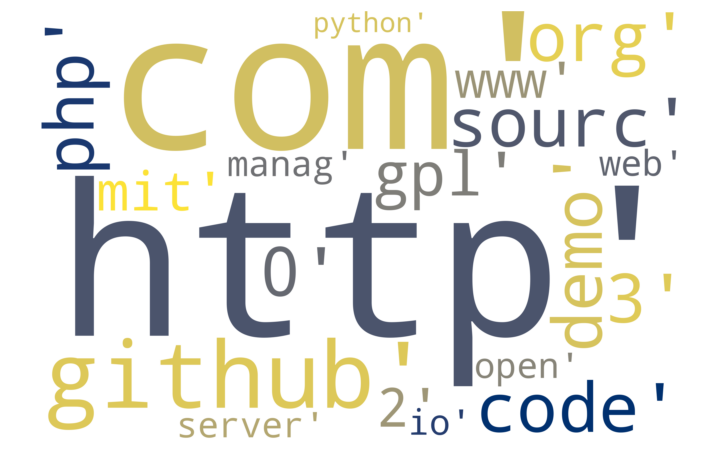

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_js_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    colormap=plt.cm.cividis,
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thoughts:**
>- JavaScript: It makes sense that 'http', 'com', and 'org' are in the top twenty in a programming language that is used heavily in web design.
>- Further Investigation: Why is 'python' in the Top 20 words??
>- Does 'mit' refer to MIT or is it just some kind of truncation from stemming.

### Python Word Frequency Visuals

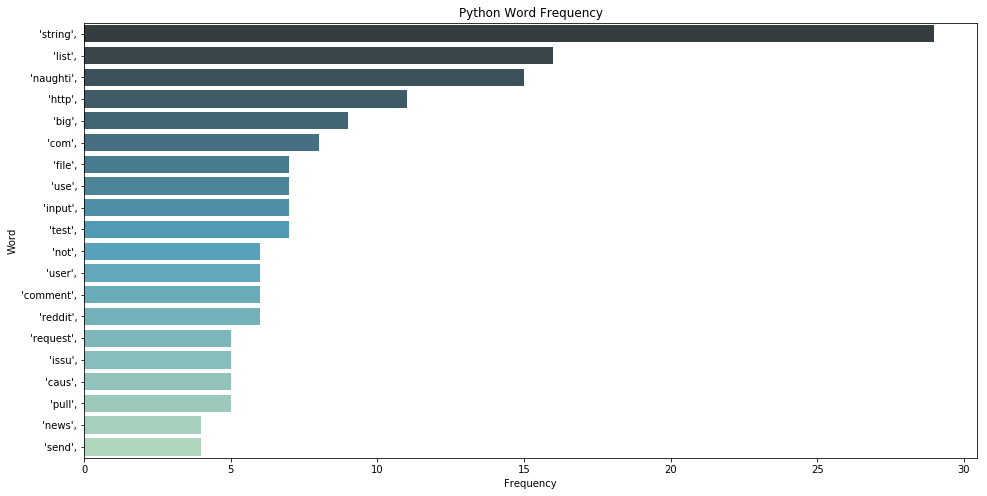

In [18]:
plt.figure(figsize=(16,8))
sns.barplot(top_20_py_words.freq, top_20_py_words.words, palette='GnBu_d')

plt.title('Python Word Frequency')
plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

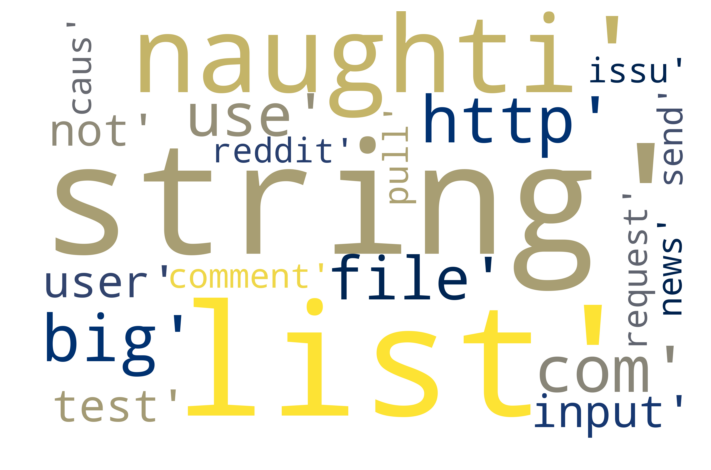

In [19]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_py_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    colormap=plt.cm.cividis,
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Thoughts:**
>- Why are the python readme's so naughti??
>- Does the high frequency of 'list' refer to a problem with the usability of list within python? or does it simply mean that a list is one of the most comon ways to solve a problem in python?
>- Do python programmers have a difficult time using git ('pull')?
>- Does 'request' correlate with readme's which involve webscrapping?
>- Are subreddit's a more common source for Q/A for python programmers than other programming forums?
>- Does 'test' refer to articles which involve machine learning?

### Go programming language Word Frequency Visuals

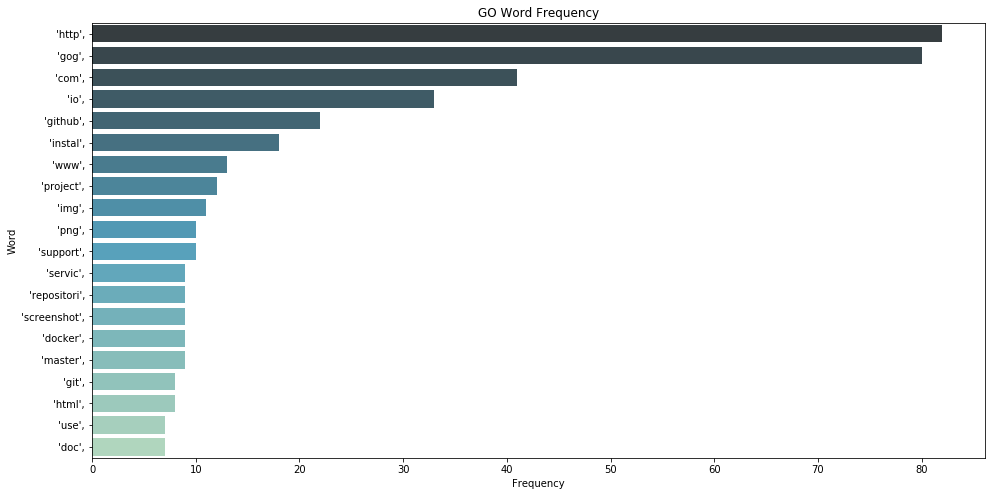

In [20]:
plt.figure(figsize=(16,8))
sns.barplot(top_20_go_words.freq, top_20_go_words.words, palette='GnBu_d')

plt.title('GO Word Frequency')
plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

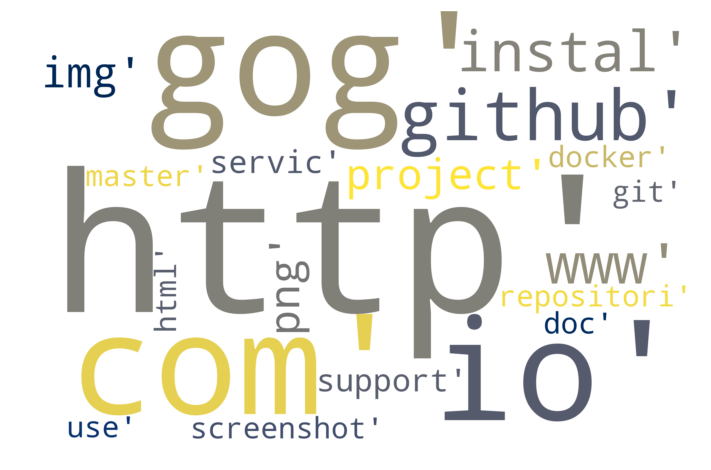

In [21]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_go_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    colormap=plt.cm.cividis,
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thoughts:**
>- The word frequency seems to indicate that GO is used mostly for web design.
>- Having 'png', 'img' and 'screenshot' might indicate that GO is better for utilization of image files.

### Questions to Answer
- What are the most common words in READMEs?  
- What does the distribution of IDFs look like for the most common words?    
- Do different languages use a different number of unique words?

**Building a web that shows which words are unique and those which have commonality, throughout the top six languages.**

In [22]:
import networkx as nx

/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


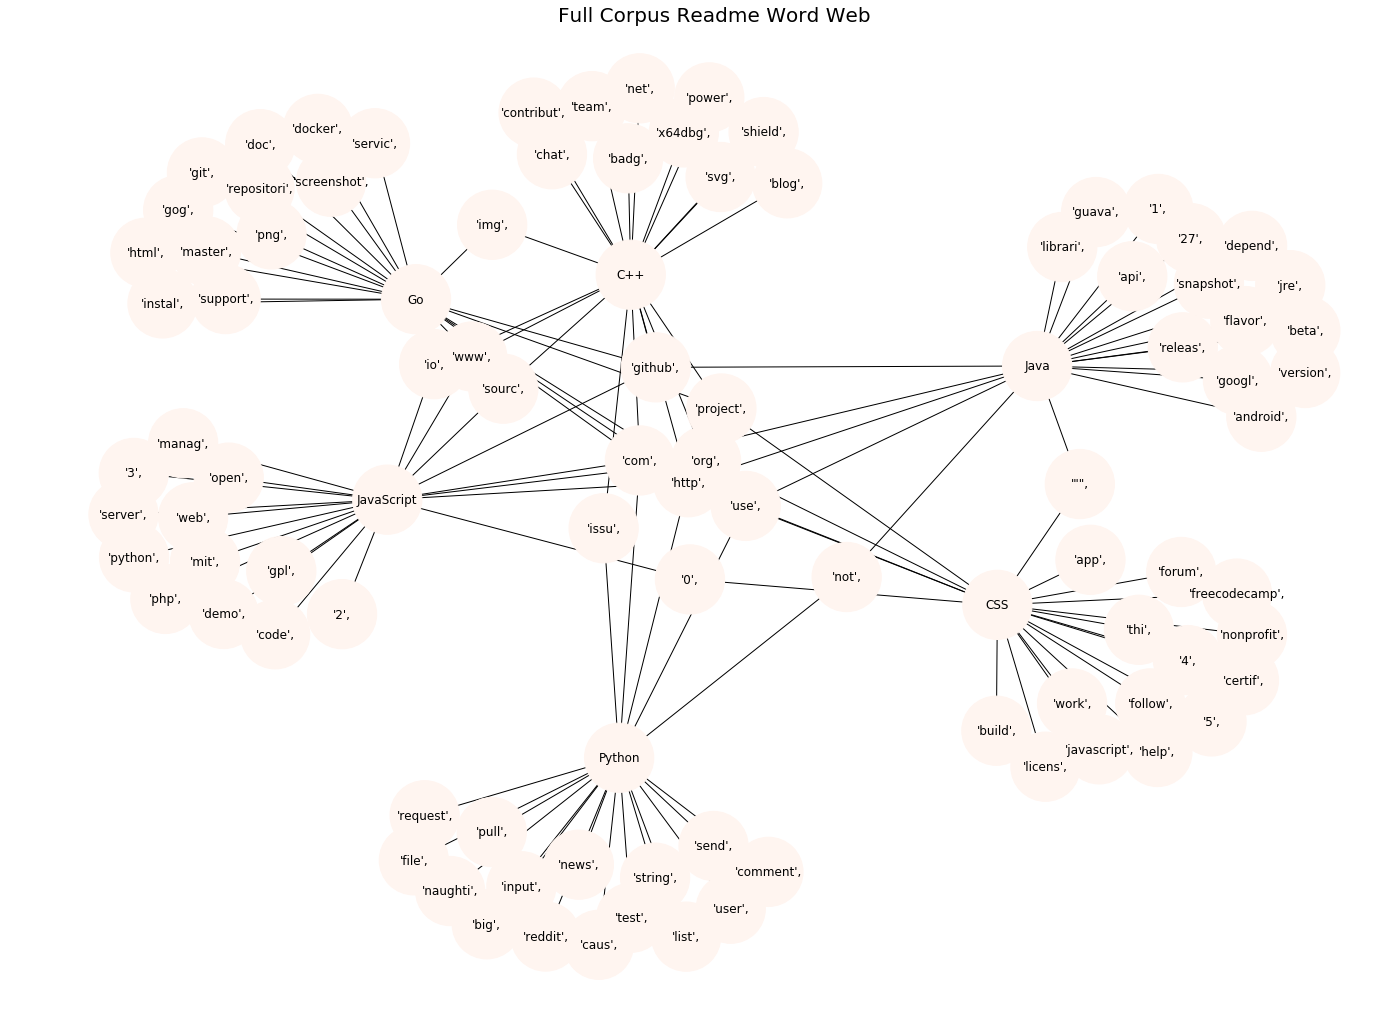

In [23]:
G = nx.Graph()
plt.figure(3,figsize=(24,18)) 

for word in top_20_py_words.words:
    G.add_edge('Python', word)

for word in top_20_go_words.words:
    G.add_edge('Go', word)

for word in top_20_js_words.words:
    G.add_edge('JavaScript', word)
    
for word in top_20_java_words.words:
    G.add_edge('Java', word)

for word in top_20_cplus_words.words:
    G.add_edge('C++', word)

for word in top_20_css_words.words:
    G.add_edge('CSS', word)


values = [1.0 for node in G.nodes()]
edge_colours = ['black' for edge in G.edges()]
black_edges = [edge for edge in G.edges()]

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('Reds'), node_color = values, node_size=4800)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=True)
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')

plt.title('Full Corpus Readme Word Web', fontsize=20)
plt.axis('off')
plt.show()

**Explanation:**
> We used the top 20 words in each language to build a word network. Each programming language contains certain unique words and words that are common in multiple languages. The Network shows the programming language as a unique node and the edges show the word relationship between the languages. From here we can answer the questions above.

### ---Exploraion Complete---

## Modeling <a name="modeling"></a>

**Bring in multiple classification models**
> TF-IDF  
> Logistic Regression  
> Decision Tree (Best Train Model)  
> Random Forest  
> KNN

### Feature Extraction: TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
vectorizer = TfidfVectorizer()

In [26]:
features = vectorizer.fit_transform(df.readme_clean.values)  
features = features.todense()

features.shape

(108, 19464)

**There are 19,464 unique words out of 108 different documents**

**List of unique words**

In [27]:
feature_names = vectorizer.get_feature_names()
print(feature_names[:10])

['00', '000', '0000', '00000000', '00042', '000z', '001', '0010', '0033ff', '004']


**Create a Dataframe with the new features**

In [28]:
tf_idf = pd.DataFrame(data=features,
                  columns=feature_names)
tf_idf.head()

,00,000,0000,00000000,00042,000z,001,0010,0033ff,004,...,zxing,zy,zy3qpxmz,zydi,zyecca,zynga,zyszi,zyszys98,zyuwsjuxxuq,zzfhjytdceu
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.027863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002974,0.0,0.0,0.0,0.0,0.002429,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


**Thoughts:**
>- Highly unique words are likely usernames; especially if ending with two numbers. Could do further research to determine if that is accurate.

### Train-Test Split
>- Make sure the dataframe does not include NaN values
>- Make sure the languages contain more than one readme for the classification methods to work

**Drop all null values**

In [29]:
df.replace('-', np.nan, inplace = True)
df = df.dropna()

**Clean up our dataframe**
>- Take out all languages with only 1 or 2 README files and remove them
>- We could build a loop here, but we just want to push through to modeling; too few to bother

In [30]:
df = df[df.language != 'Rust']
df = df[df.language != 'C']
df = df[df.language != 'Assembly']
df = df[df.language != 'Dart']
df = df[df.language != 'TypeScript']
df = df[df.language != 'C#']
df = df[df.language != 'PHP']
df = df[df.language != 'Swift']
df = df[df.language != 'Ruby']
df = df[df.language != 'Jupyter Notebook']
df = df[df.language != 'Swift']
df = df[df.language != 'HTML']

**Could probably write a function for this later so that it can be cycled through any programming language that is not listed here.**

### Import multiple sklearn algorithms so that we can build modles

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

**Split our data into independent and dependent variables**

In [32]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_clean)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

### Logistic Regression

In [33]:
lm = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=120, verbose=True).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [34]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 85.51%
---
Confusion Matrix
actual      C++  CSS  Go  Java  JavaScript  Python
predicted                                         
C++           2    0   0     0           0       0
Go            0    0   4     0           0       0
Java          0    0   0     2           0       0
JavaScript    3    2   2     3          34       0
Python        0    0   0     0           0      17
---
              precision    recall  f1-score   support

         C++       1.00      0.40      0.57         5
         CSS       0.00      0.00      0.00         2
          Go       1.00      0.67      0.80         6
        Java       1.00      0.40      0.57         5
  JavaScript       0.77      1.00      0.87        34
      Python       1.00      1.00      1.00        17

   micro avg       0.86      0.86      0.86        69
   macro avg       0.80      0.58      0.64        69
weighted avg       0.86      0.86      0.83        69



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Tree Classification Method

In [35]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [36]:
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

In [37]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.99


In [38]:
confusion_matrix(y_train, y_pred)

array([[ 4,  0,  1,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0],
       [ 0,  0,  6,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0, 34,  0],
       [ 0,  0,  0,  0,  0, 17]])

In [39]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.61


### Random Forest Classification Method

In [40]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [41]:
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)

In [42]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.64


In [43]:
print(confusion_matrix(y_train, y_pred))

[[ 0  0  0  0  5  0]
 [ 0  0  0  0  2  0]
 [ 0  0  0  0  5  1]
 [ 0  0  0  0  5  0]
 [ 0  0  0  0 34  0]
 [ 0  0  0  0  7 10]]


### KNN Classifier

In [44]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [45]:
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)

In [46]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.75


In [47]:
print(confusion_matrix(y_train, y_pred))

[[ 2  0  0  0  2  1]
 [ 0  0  0  0  2  0]
 [ 0  0  5  0  1  0]
 [ 0  0  0  4  0  1]
 [ 0  0  0  0 26  8]
 [ 0  0  0  0  2 15]]


([<matplotlib.axis.XTick at 0x1a2ac9e710>,
 <a list of 5 Text xticklabel objects>)

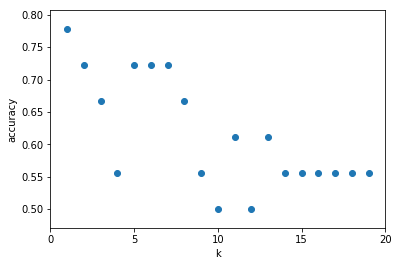

In [48]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

**Thoughts:**
>- There are three distinct groupings using KNN

### ---Exploration Complete---

### Summarize Conclusions <a name="summary"></a>
>- Decistion Tree Classification Method performed the best with multinominal data 89% train 96% test.  
>- Hypothesis Result: C++ programming README's unique words include: 'power', 'shield', 'team', and 'badge'. C++ programmers may have a minor superiority complex, but the unique vocabulary does make them an elitist.

### Find different ways to improve model:
>- Use Googles' Word2vec dictionary to assign the words in each read me a key that will hopefully improve each model
>- Use and define each programming language's Sentiment Analysis
>- Print the polarity for sentiment analysis in a dataframe
>- Utilize Latent Dirichlet Allocation

### Other Thoughts:
>- Split the project into three notebooks:
   - Exploration
   - Modeling
   - Just the code
       - Easier reproducibility in terms of code transferring

>- Does the length of the README vary by language?